In [1]:
from cvxopt import solvers,matrix
from env import *
from utils import *
from risks import *

def find_average(values,timestep,lookback):
    
    values_first = values[:,timestep-lookback:timestep]
    values_later = values[:,timestep-lookback+1:timestep+1]
    
    returns = (values_later - values_first)/values_first
    
    mean = np.mean(returns,axis = 1)
    
    return mean

In [2]:
def experiment(R,start,end):
    env = Enviroment(start = start, end = end,weights=True)
    port = [0.0 for _ in range(29)]

    for day in range(start,end):

        if bool(day_names_signals[day]):
            sigma = sharpe(env.values,env.timestep,30)
            P = matrix(sigma)
            q = matrix([0.0 for _ in range(29)])

            A = matrix([1.0 for _ in range(29)]).trans()
            b = matrix(1.0)

            eye = -np.eye(29)
            returns = find_average(env.values,env.timestep,30)
            G = matrix(np.vstack([eye,returns]))
            h = matrix([0.0 for _ in range(29)] + [-R])

            solvers.options['show_progress'] = False
            try:
                solution = solvers.qp(P,q,G,h,A,b)

                sol = []
                for i in solution['x']:
                    if i<0.001:
                        sol.append(0)
                    else:
                        sol.append(i)
                port = sol
            except:
                pass

            port = env.step(port)

        else:
            port = env.step(port)
    env.step([0 for _ in range(29)])

    return env

In [3]:
# Find best R in validation

scores = []
for R in np.arange(0,0.005,0.00005):
    env = experiment(R,400,1750)
    
    result = env.valuation
    scores.append(result)
    
scores = [i - 10000 for i in scores]

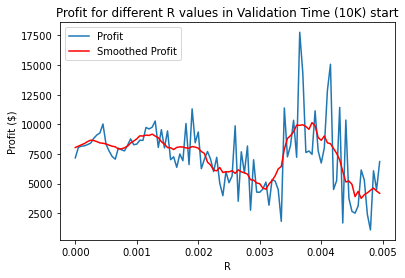

In [4]:
from numpy import mean
smoothed_scores = [mean(scores[max(0,i-5):min(i+5,len(scores))]) for i in range(1,len(scores)+1)]

import matplotlib.pyplot as plt
plt.plot(np.arange(0,0.005,0.00005), scores,label = 'Profit')
plt.plot(np.arange(0,0.005,0.00005), smoothed_scores,label = 'Smoothed Profit',color = 'red')
plt.legend()
plt.xlabel('R')
plt.ylabel('Profit ($)')
plt.title('Profit for different R values in Validation Time (10K) start')

plt.show()

In [6]:
best_R = smoothed_scores.index(max(smoothed_scores))
best_R = np.arange(0,0.005,0.00005)[best_R]

print(f'Best R is {best_R}.')

Best R is 0.00385.


In [7]:
max(smoothed_scores)

10143.901364773561